# Binary Classification Model for Kaggle Tabular Playground Series 2021 March Using Python and AutoKeras
### David Lowe
### January 10, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Mar 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: After a series of tuning trials, the best AutoKeras model processed the training dataset with a ROC/AUC score of 88.06%. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 87.82%.

CONCLUSION: In this iteration, the AutoKeras model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 March Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-mar-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-mar-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Jan  9 18:21:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     On   | 00000000:00:05.0 Off |                  N/A |
| 30%   29C    P5    15W / 125W |      1MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 31.6 gigabytes of available RAM



In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
import keras_tuner
import autokeras as ak

2022-01-09 18:21:48.954960: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC()]
MAX_EPOCHS = 10
BATCH_SIZE = 32
MAX_TRIALS = 10

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

2022-01-09 18:21:50.095624: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


Num GPUs Available: 1
TensorFlow version: 2.5.2


2022-01-09 18:21:50.138242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 18:21:50.138847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-09 18:21:50.138897: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-09 18:21:50.144429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-09 18:21:50.144526: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-01-09 18:21:50.147083: I tensorflow/stream_executor/platfo

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv

In [14]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont2     cont3  \
0   0    A    I    A    B    B   BI    A    S    Q  ...  0.759439  0.795549   
1   1    A    I    A    A    E   BI    K    W   AD  ...  0.386385  0.541366   
2   2    A    K    A    A    E   BI    A    E   BM  ...  0.343255  0.616352   
3   3    A    K    A    C    E   BI    A    Y   AD  ...  0.831147  0.807807   
4   4    A    I    G    B    E   BI    C    G    Q  ...  0.338818  0.277308   

      cont4     cont5     cont6     cont7     cont8     cont9    cont10 target  
0  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006  0.665915      0  
1  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406  0.493729      0  
2  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696  0.549452      0  
3  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318  0.934242      0  
4  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084  0.328960      1  

[5 rows x 32 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [16]:
print(df_dataset_import.describe())

                  id          cont0          cont1          cont2  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean   250183.425697       0.504749       0.494073       0.516632   
std    144320.334812       0.206788       0.213037       0.214851   
min         0.000000      -0.049562       0.084480       0.094493   
25%    125399.750000       0.344985       0.317363       0.326047   
50%    250192.500000       0.479650       0.463170       0.471247   
75%    375246.250000       0.637657       0.693992       0.704625   
max    499999.000000       1.004559       1.009958       1.016600   

               cont3          cont4          cont5          cont6  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.474235       0.504848       0.502257       0.488229   
std         0.216636       0.227474       0.241243       0.211335   
min        -0.045316       0.168071      -0.036379       0.005199   
25%         0.292249       0.2793

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    220539
1     79461
dtype: int64


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont2     cont3  \
0    A    I    A    B    B   BI    A    S    Q    A  ...  0.759439  0.795549   
1    A    I    A    A    E   BI    K    W   AD    F  ...  0.386385  0.541366   
2    A    K    A    A    E   BI    A    E   BM    L  ...  0.343255  0.616352   
3    A    K    A    C    E   BI    A    Y   AD    F  ...  0.831147  0.807807   
4    A    I    G    B    E   BI    C    G    Q    A  ...  0.338818  0.277308   
5    A    I    C    A    E   BI    C   AV    Y    C  ...  0.524760  0.580085   
6    A    A    G    A    H   BI    A    S   AD    E  ...  0.678466  0.747125   
7    A    F    A    A    I   BI    C   AF   AG    A  ...  0.943545  0.209744   
8    B    I    A    A    E   BI    C   AK   AE    E  ...  0.635195  0.672264   
9    A    L    A    B    E   BI    C   AF   AX    A  ...  0.397622  0.506096   

      cont4     cont5     cont6     cont7     cont8     cont9    cont10  \
0  0.681917  0.621672  0.592184  0.791921  0

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [21]:
print(df_dataset_import.describe())

               cont0          cont1          cont2          cont3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504749       0.494073       0.516632       0.474235   
std         0.206788       0.213037       0.214851       0.216636   
min        -0.049562       0.084480       0.094493      -0.045316   
25%         0.344985       0.317363       0.326047       0.292249   
50%         0.479650       0.463170       0.471247       0.387564   
75%         0.637657       0.693992       0.704625       0.644950   
max         1.004559       1.009958       1.016600       0.952187   

               cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504848       0.502257       0.488229       0.501739   
std         0.227474       0.241243       0.211335       0.203496   
min         0.168071      -0.036379       0.005199       0.090901   
25%         0.279303       0.2764

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


In [23]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    220539
1     79461
dtype: int64


### 1.e) Splitting Data into Sets

In [24]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (300000, 31) df_features_import.shape: (300000, 30) df_target_import.shape: (300000,)


In [25]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (240000, 30) df_target_train.shape: (240000,)
df_features_test.shape: (60000, 30) df_target_test.shape: (60000,)


### 1.f) Set up the parameters for data visualization

In [26]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [27]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

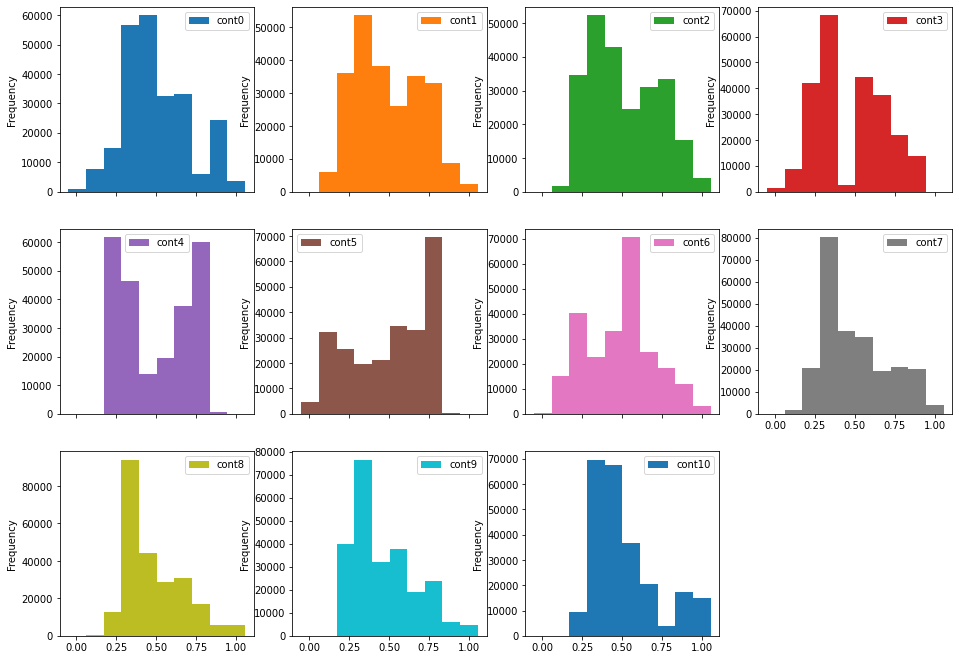

In [29]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

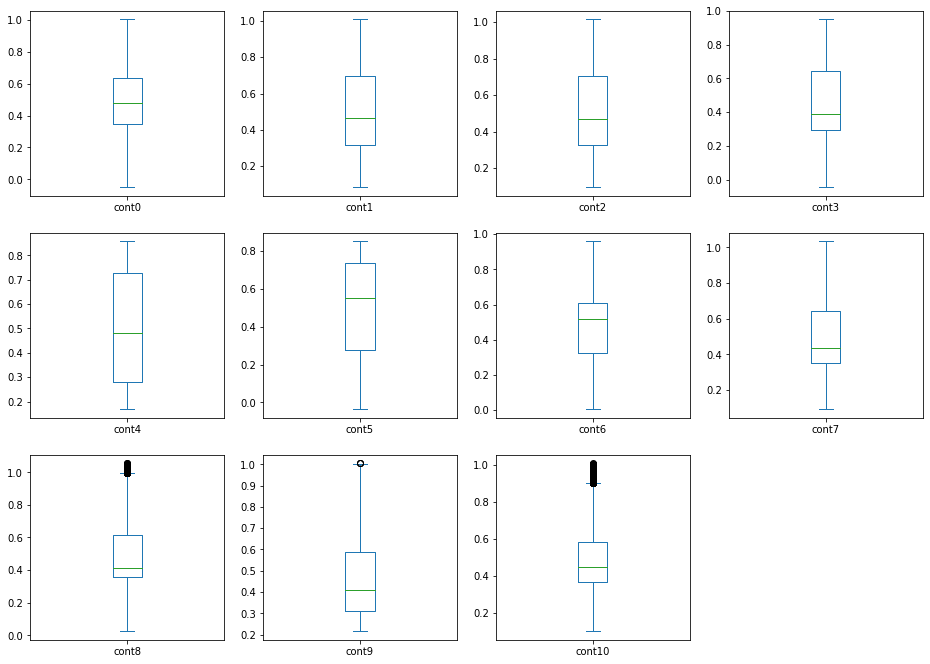

In [30]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

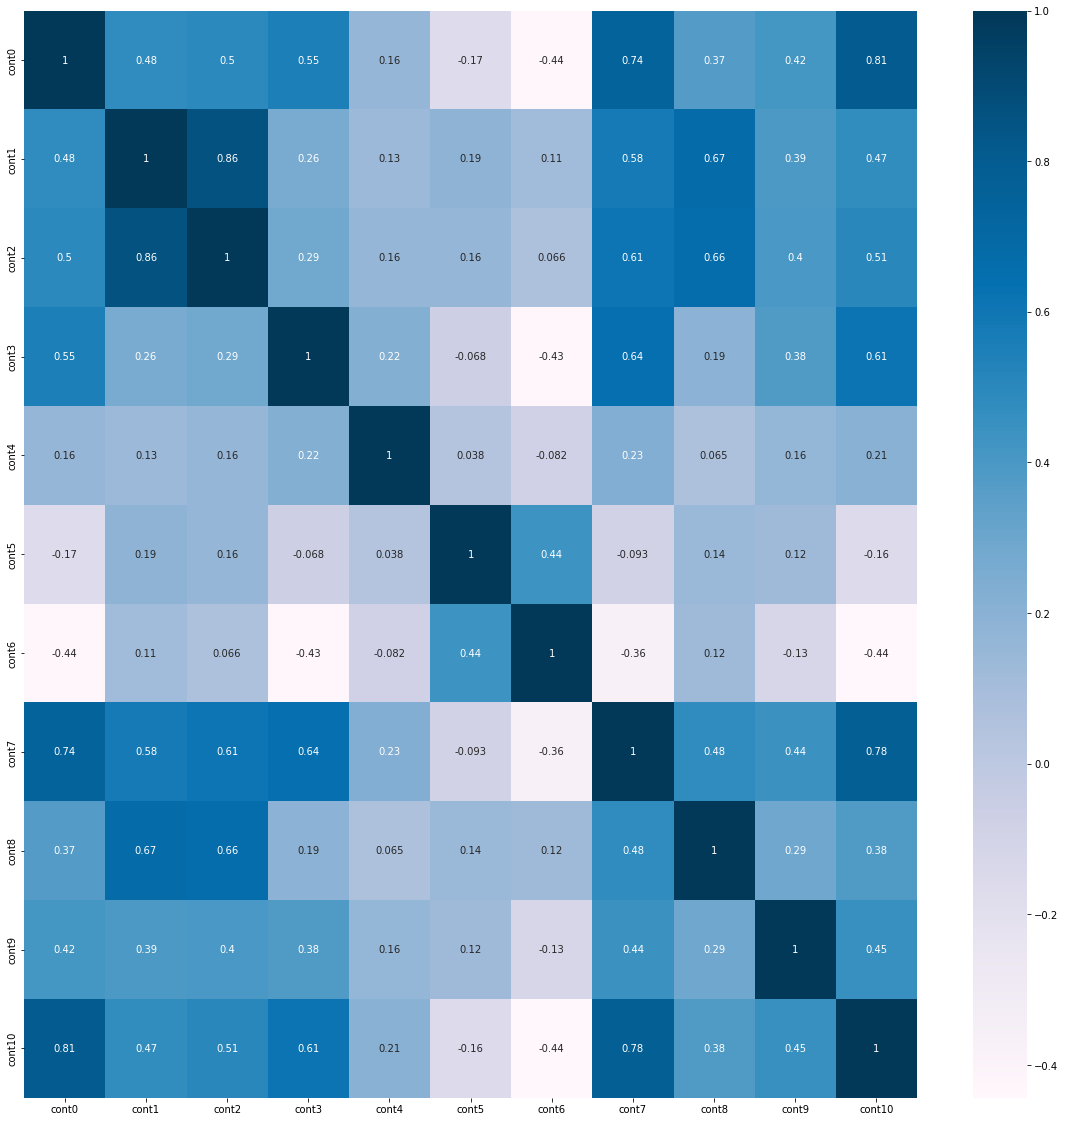

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [32]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [34]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
#     ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 11
Number of categorical columns: 19
Total number of columns in the feature dataframe: 30


In [35]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (240000, 30) to array_features_train.shape: (240000, 30)


### 3.b) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

In [37]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [38]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [39]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=RNG_SEED)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [40]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.to_numpy()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (240000, 30) array_target_train.shape: (240000,)


In [41]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
start_time_module = datetime.now()
reset_random()
auto_model = ak.StructuredDataClassifier(loss=DEFAULT_LOSS,
                                      metrics=DEFAULT_METRICS,
                                      max_trials=MAX_TRIALS,
                                      objective=keras_tuner.Objective("val_auc", direction="max"),
                                      seed=RNG_SEED)
auto_model.fit(x=array_features_train,
               y=array_target_train,
               epochs=MAX_EPOCHS,
               validation_split=VAL_SET_RATIO,
               batch_size=BATCH_SIZE,
               verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 10 Complete [00h 10m 00s]
val_auc: 0.8806027770042419

Best val_auc So Far: 0.8806027770042419
Total elapsed time: 01h 25m 09s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
7500/7500 [==============================] - 56s 7ms/step - loss: 0.4143 - auc: 0.8507
Epoch 2/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3972 - auc: 0.8586
Epoch 3/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3932 - auc: 0.8615
Epoch 4/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3911 - auc: 0.8634
Epoch 5/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3900 - auc: 0.8641
Epoch 6/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3888 - auc: 0.8649
Epoch 7/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3879 - auc: 0.8655
Epoch 8/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3873 - auc: 0.8658
Epoch 9/10
7500/7500 [=======================

2022-01-09 19:59:20.758078: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Total time for model fitting: 1:37:22.977555


In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [46]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 30)                0         
_________________________________________________________________
normalization (Normalization (None, 30)                61        
_________________________________________________________________
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

### 5.b) Load Test Dataset and Make Predictions

In [47]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv

In [48]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont1     cont2  \
0   5    A    F    A    A    F   BI    A   AH   AX  ...  0.735690  0.578366   
1   6    A    H    C    A    E   AB    I    F    N  ...  0.313703  0.928885   
2   8    A    N    C    A    F   AB    A   AH   BC  ...  0.448201  0.424876   
3   9    B    L    C    A    F   BI    A    E   AX  ...  0.666092  0.598943   
4  11    A    F    A    B    F   BI    A   AH    I  ...  0.772229  0.479572   

      cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331  0.359987   
1  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944  0.565520   
2  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238  0.252289   
3  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660  0.348514   
4  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491  0.466261   

     cont10  
0  0.947489  
1  0.388580  
2  0.411592  
3  0.325723  
4  0

In [49]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   5
1   6
2   8
3   9
4  11


In [50]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont1     cont2  \
0    A    F    A    A    F   BI    A   AH   AX    A  ...  0.735690  0.578366   
1    A    H    C    A    E   AB    I    F    N    A  ...  0.313703  0.928885   
2    A    N    C    A    F   AB    A   AH   BC    A  ...  0.448201  0.424876   
3    B    L    C    A    F   BI    A    E   AX    A  ...  0.666092  0.598943   
4    A    F    A    B    F   BI    A   AH    I    A  ...  0.772229  0.479572   

      cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331  0.359987   
1  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944  0.565520   
2  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238  0.252289   
3  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660  0.348514   
4  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491  0.466261   

     cont10  
0  0.947489  
1  0.388580  
2  0.411592  
3  0.325723 

In [51]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (200000, 30) to array_features_test.shape: (200000, 30)


In [52]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[0.07406274]
 [0.5206901 ]
 [0.03517718]
 ...
 [0.7438121 ]
 [0.12015292]
 [0.3140151 ]]


In [53]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   5  0.074063
1   6  0.520690
2   8  0.035177
3   9  0.099358
4  11  0.089178


In [54]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20220109-1959.csv


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 1:37:58.164449
